In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sk
from decimal import Decimal
from sklearn import linear_model
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier as ovr
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Regression

In [2]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
dtype = {'BitRate': np.float64, 'FreezeRatio': np.float64, 'Freezes': np.int32, 'Freezelength': np.float64, 'Quality': np.float64}
df = pd.read_table('~/Projects/VQA_nonDL/data/regression-data.txt', delim_whitespace=True, dtype = dtype)
df['BitRate'] /= 100  # transforming BitRate to percentages

In [4]:
# get (X, y) and set fold
features = ['BitRate', 'FreezeRatio']
X, y = np.array(df[features]), np.array(df['Quality'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3333, random_state = 1)
fold = 4

In [5]:
regressors = {'Random Forest': RandomForestRegressor(random_state = 1), 
               'Nearest Neighbors': KNeighborsRegressor(),
               'SVM': SVR(),
               'MLP': MLPRegressor(random_state = 1, max_iter = 10000),
               'AdaBoost': AdaBoostRegressor(random_state = 1)
              }

params = {'Random Forest': {'n_estimators': range(1, 21), 'criterion': ('mse', 'mae')},
          'Nearest Neighbors': {'n_neighbors':range(1, 11)},
          'SVM': {'kernel':('poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 10]},
          'MLP': {'hidden_layer_sizes': [(10,), (20,), (40,), (80,), (10,10), (20, 20), (40, 40), (80, 80)], 
                  'alpha': [0.0001, 0.001, 0.01, 0.1],
                  'activation': ('logistic', 'tanh', 'relu'), 
                  'solver': ('lbfgs', 'sgd', 'adam')},
          'AdaBoost': {'n_estimators': [10, 20, 40, 80], 'learning_rate': [0.01, 0.1, 1, 10]}
         }

In [6]:
# function for obtaining best estimator using grid search
def grid_search_reg(X, y, estimator, params, scoring, fold):
    reg = GridSearchCV(estimator, params, scoring = scoring, cv=fold)
    reg.fit(X, y)
    return (reg.best_estimator_, reg.best_score_)

In [7]:
scoring = 'neg_mean_squared_error'
best_regressors = {}
for k in regressors:
    best_regressors[k], _ = grid_search_reg(X_train, y_train, regressors[k], params[k], scoring, fold)

In [8]:
def to_label(score, thresh_1, thresh_2):
    labels = []
    for x in np.nditer(score, op_flags=['readonly']):
        if x < thresh_1:
            labels.append(0)
        elif x < thresh_2:
            labels.append(1)
        else:
            labels.append(2)
    return np.array(labels)

def optimize_thresh(regressor, X_train, y_train, t1_range):
    i = 0
    thresh_accuracy = []
    pred = regressor.fit(X_train, y_train).predict(X_train) 
    # find optimal thresholds from training set
    for t1 in t1_range:
        for t2 in np.arange(t1+1, 4.01, 0.05):
            y_train_lb = to_label(y_train, t1, t2)
            pred_lb = to_label(pred, t1, t2)
            thresh_accuracy.append(((t1, t2), accuracy_score(y_train_lb, pred_lb)))
    thresh_accuracy.sort(key = lambda x:x[1])
    return thresh_accuracy[-1]

In [9]:
best_regressors

{'AdaBoost': AdaBoostRegressor(base_estimator=None, learning_rate=0.1, loss='linear',
          n_estimators=80, random_state=1),
 'MLP': MLPRegressor(activation='tanh', alpha=0.1, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(10, 10), learning_rate='constant',
        learning_rate_init=0.001, max_iter=10000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
        solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
        warm_start=False),
 'Nearest Neighbors': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform'),
 'Random Forest': RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1

In [11]:
t1_range = np.arange(2, 3.01, 0.05)
mse = {}
thresh = {}
accuracy = {}

for k, reg in best_regressors.items():
    thresh[k] = optimize_thresh(reg, X_train, y_train, t1_range)
    pred = reg.predict(X_test)
    mse[k] = mean_squared_error(y_test, pred)
    y_test_lb = to_label(y_test, thresh[k][0][0], thresh[k][0][1])
    pred_lb = to_label(pred, thresh[k][0][0], thresh[k][0][1])
    accuracy[k] = accuracy_score(y_test_lb, pred_lb)

In [14]:
accuracy

{'AdaBoost': 0.78,
 'MLP': 0.86,
 'Nearest Neighbors': 0.83,
 'Random Forest': 0.84,
 'SVM': 0.76}

# Visualization

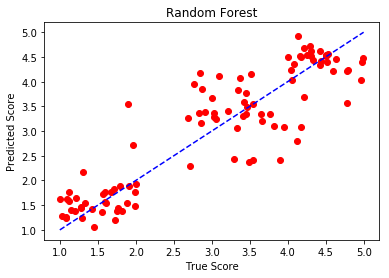

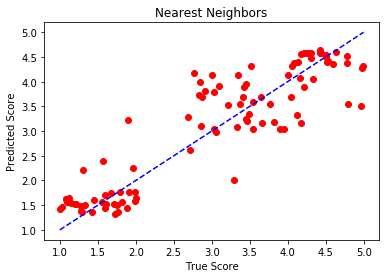

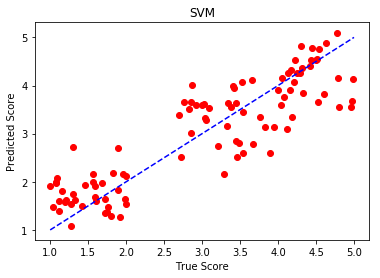

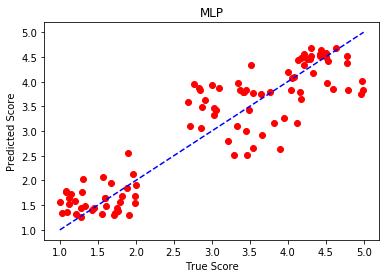

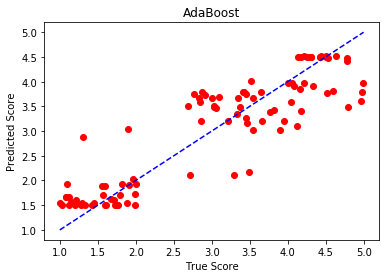

In [15]:
for k, reg in best_regressors.items():
    y_pred = reg.fit(X_train, y_train).predict(X_test)
    plt.scatter(y_test, y_pred, color = 'r')
    plt.plot([1, 5], [1, 5], color='b', linestyle='dashed')
    plt.xlabel('True Score')
    plt.ylabel('Predicted Score')
    plt.title(k)
    plt.show()

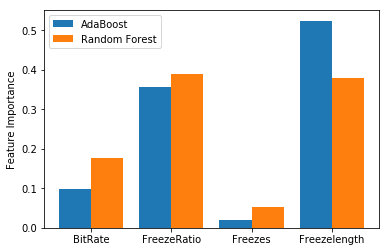

In [21]:
p1 = plt.bar(np.arange(len(features)), best_regressors_mse['AdaBoost'].feature_importances_, width = -0.4, align = 'edge')
p2 = plt.bar(np.arange(len(features)), best_regressors_mse['Random Forest'].feature_importances_, width = 0.4, align = 'edge')
plt.xticks(np.arange(len(features)), tuple(features))
plt.ylabel('Feature Importance')
plt.legend((p1, p2), ('AdaBoost', 'Random Forest'))
plt.show()